# JPAD test within Jupyter running a BeakerX Groovy kernel

— Agostino De Marco, University of Naples Federico II

JPAD stands for *Java Program toolchain for Aircraft Designers*. JPAD is a Java software library containing classes and utility functions that can be used to build software systems. Typically, these are calculation programs providing aerodynamic and performance predictions for given aircraft designs.

<img src="./images/IRONa.png" width="60%" />

JPAD is open source and its [public repository is on GitHub](https://github.com/Aircraft-Design-UniNa/jpad).


This Jupyter notebook uses the [BeakerX Groovy kernel](http://beakerx.com). The purpose is demonstrating:

- the use of Java & Groovy with Jupyter
- the use of JPAD and its companion external native libraries in the context of a notebook

## Running this notebook

Let us print the current directory content. We are Java users, so let start using Java in our first code cell to this purpose:

In [1]:
// new File(".").eachFile() { file -> println file.getName() }  
def dirItems = []
("." as File).eachFile groovy.io.FileType.ANY, {
    dirItems << it
}
def result = dirItems.sort{ a,b -> b.lastModified() <=> a.lastModified() }*.name

[Test_JPAD_3.ipynb, images, Test_JPAD_2.ipynb, .ipynb_checkpoints, jar, tmp, ;, Test_JPAD_1.ipynb, beakerx-jpad.bat, lib]

This notebook is named `Test_JPAD_3.ipynb`. The `jar` subdirectory contains the two Jar files

- `JPADConfigs_DDMM2018.jar`
- `JPADCore_v2_DDMM2018.jar`

where JPAD is bundled, and all the Jar's that JPAD depends upon.

In addition, the The `lib` subdirectory contains all the native libraries (Win64) needed for JPAD to work correctly.

## Preliminaries

### Classpath extras

The following cell uses BeakerX *magic command* `%classpath` that directs the Groovy kernel to include all the Jar files located in the path `./jar`. The command `%classpath` alone prints out all the included Jars.

In [2]:
%classpath add jar .\jar\*

Added jars: [JPADCore_v2_03042018.jar, xstream-1.4.7.jar, jarh4obj.jar, jxls-core-1.0.5.jar, jarh5obj.jar, flanagan.jar, dom4j-1.6.1.jar, log4j-1.2.13.jar, xmlbeans-2.6.0.jar, JPADConfigs_31032018.jar, processing-core.jar, freebuilder-1.10.5.jar, commons-codec-1.5.jar, jfreesvg-3.0.jar, MOEAFramework-2.12.jar, jdom-2.0.5.jar, unit-api-0.6.1.jar, commons-lang3-3.7.jar, jarhdf-2.10.1.jar, vecmath.jar, trove-3.1a1.jar, commons-logging-1.1.jar, slf4j-api-1.7.5.jar, jfreechart-1.5.0.jar, jarhdfobj.jar, jxls-reader-1.0.5.jar, orsonpdf-1.7.jar, fxgraphics2d-1.3.jar, commons-logging-1.2.jar, jfreesvg-3.3.jar, commons-math3-3.6.1.jar, log4j-core-2.0.2.jar, commons-jexl-2.1.1.jar, reflectutils-0.9.16.jar, jarhdf5-2.10.1.jar, jfreechart-nofx-2.0-pre1.jar, commons-collections4-4.0.jar, javaslang-2.0.4.jar, gtmat.jar, orsoncharts-1.5.jar, poi-3.10.1-20140818.jar, junit-4.11.jar, tigl-2.2.1.jar, stax-api-1.0.1.jar, jscience.jar, log4j-api-2.0.2.jar, guava-16.0.1.jar, poi-ooxml-3.10.1-20140818.jar, i

### Check the native libs

The native libs stored in the `./lib` directory are listed by the following code cell.

In [3]:
def libFiles = []
("./lib" as File).eachFile groovy.io.FileType.FILES, {
    libFiles << it
}
def result = libFiles.sort{ a,b -> b.lastModified() <=> a.lastModified() }*.name

[msvcp100.dll, msvcr100.dll, tbb.dll, tbbmalloc.dll, TIGL.dll, TIGL.lib, TIXI.dll, vcomp100.dll, libhdf5.lib, libjpeg.lib, libmfhdf.lib, libszip.lib, libxdr.lib, libzlib.lib, jhdf.dll, jhdf.lib, jhdf5.dll, jhdf5.lib, libhdf.lib]

## Calling JPAD functions

At this point we can start using the JPAD API functions.

### Global scope imports

The following are BeakerX *magics*, a bunch of `%import` commands that make a set of Java packages globally visible by all the subsequent code cells.

In [4]:
%import java.io.File
%import java.io.IOException
%import java.io.OutputStream
%import java.io.PrintStream

%import java.nio.file.Path
%import java.nio.file.Paths
%import java.nio.file.Files

%import java.util.ArrayList
%import java.util.List
%import java.util.stream.Collectors

%import javax.measure.quantity.*
%import javax.measure.unit.SI
%import javax.measure.unit.NonSI


%import org.jscience.physics.amount.Amount

%import org.apache.poi.openxml4j.exceptions.InvalidFormatException

%import ncsa.hdf.hdf5lib.exceptions.HDF5LibraryException

%import configuration.*
%import configuration.enumerations.*

%import aircraft.*
%import aircraft.components.*

%import aircraft.components.FuelTank

%import aircraft.components.fuselage.*
%import aircraft.components.liftingSurface.*
%import aircraft.components.liftingSurface.creator.*
%import aircraft.components.nacelles.*
%import aircraft.components.powerplant.*

// TODO: analyses
// TODO: cad

%import calculators.*
%import calculators.aerodynamics.*
%import calculators.balance.*
%import calculators.costs.*
%import calculators.geometry.*
%import calculators.performance.*
%import calculators.stability.*
%import calculators.weights.*

%import database.*
%import database.databasefunctions.*
%import database.databasefunctions.aerodynamics.*
%import database.databasefunctions.aerodynamics.fusDes.*
%import database.databasefunctions.aerodynamics.vedsc.*
%import database.databasefunctions.engine.*

%import standaloneutils.*
%import standaloneutils.atmosphere.*
%import standaloneutils.cpacs.*
%import standaloneutils.customdata.*
%import standaloneutils.database.*
%import standaloneutils.jsbsim.*
%import standaloneutils.launchers.*
%import standaloneutils.mathtools.*
%import standaloneutils.aerotools.*

%import standaloneutils.aircraft.*

%import writers.*

## Setup database files and create an Aircraft object: class JPADTest

We will read the input file ../in/aircraft_IRON_NEW.xml that defines a specific aircraft design named IRON. The following image is a top view of this airplane.

<img src="./images/IRONc.png" width="60%" />

To do so we create a test class named `JPADTest` and an objects `jpadTest` of this class that incorporates the paths to all the files necessary for JPAD to work correctly.

In [5]:
// A Java class in a Groovy code cell
public class JPADTest {
    
    public String pathToXML;
    public String aircraftFileName;
    
    public String dirAirfoil;
    public String dirFuselages;
    public String dirLiftingSurfaces;
    public String dirEngines;
    public String dirNacelles;
    public String dirLandingGears;
    public String dirCabinConfiguration;
    
    public String databaseFolderPath;
    public String inputFolderPath;
    public String outputFolderPath;

    public AerodynamicDatabaseReader aeroDatabaseReader;
    public HighLiftDatabaseReader highLiftDatabaseReader;
    public FusDesDatabaseReader fusDesDatabaseReader;
    public VeDSCDatabaseReader veDSCDatabaseReader;

    public Aircraft aircraft; // the main recipient object
    
    public Path pathToAircraftTopViewSVG = Paths.get("./images/IRON-aircraft-topview.svg");
    public Path pathToAircraftSideViewSVG = Paths.get("./images/IRON-aircraft-sideview.svg");

    public JPADTest() {        
    }

    public JPADTest(String fileName) {
        
        aircraftFileName = fileName;
        
        println "Initialize JPADTest"
        
        MyConfiguration.setDir(
            FoldersEnum.DATABASE_DIR,
            Paths.get("../data").toString()
        );
        MyConfiguration.setDir(
            FoldersEnum.INPUT_DIR,
            Paths.get("../in").toString()
        );

        MyConfiguration.setDir(
            FoldersEnum.OUTPUT_DIR,
            Paths.get("../out").toString()
        );

        String aerodynamicDatabaseFileName = "Aerodynamic_Database_Ultimate.h5";
        String highLiftDatabaseFileName = "HighLiftDatabase.h5";
        String fusDesDatabaseFilename = "FusDes_database.h5";
        String vedscDatabaseFilename = "VeDSC_database.h5";

        databaseFolderPath = MyConfiguration.getDir(FoldersEnum.DATABASE_DIR);
        inputFolderPath = MyConfiguration.getDir(FoldersEnum.INPUT_DIR);
        outputFolderPath = MyConfiguration.getDir(FoldersEnum.OUTPUT_DIR);

        println "Database dir: " + databaseFolderPath
        println "Input dir: " + inputFolderPath
        println "Output dir: " + outputFolderPath

        aeroDatabaseReader = DatabaseManager.initializeAeroDatabase(
            new AerodynamicDatabaseReader(
                databaseFolderPath,
                aerodynamicDatabaseFileName
                ),
            databaseFolderPath
            );

        highLiftDatabaseReader = DatabaseManager.initializeHighLiftDatabase(
            new HighLiftDatabaseReader(
                databaseFolderPath,
                highLiftDatabaseFileName),
            databaseFolderPath
            );

        fusDesDatabaseReader = DatabaseManager.initializeFusDes(
            new FusDesDatabaseReader(
                databaseFolderPath,
                fusDesDatabaseFilename),
            databaseFolderPath
            );

        veDSCDatabaseReader = DatabaseManager.initializeVeDSC(
            new VeDSCDatabaseReader(
                databaseFolderPath,
                vedscDatabaseFilename),
            databaseFolderPath
            );

        pathToXML = inputFolderPath + "/" + aircraftFileName;
        dirAirfoil = inputFolderPath + "/lifting_surfaces/airfoils";
        dirFuselages = inputFolderPath + "/fuselages";
        dirLiftingSurfaces = inputFolderPath + "/lifting_surfaces";
        dirEngines = inputFolderPath + "/engines";
        dirNacelles = inputFolderPath + "/nacelles";
        dirLandingGears = inputFolderPath + "/landing_gears";
        dirCabinConfiguration = inputFolderPath + "/cabin_configurations";

        println "Initialization done"
        
        try {

            println "Aircraft import"

            aircraft = Aircraft.importFromXML(
                this.pathToXML,
                this.dirLiftingSurfaces,
                this.dirFuselages,
                this.dirEngines,
                this.dirNacelles,
                this.dirLandingGears,
                this.dirCabinConfiguration,
                this.dirAirfoil,
                this.aeroDatabaseReader,
                this.highLiftDatabaseReader,
                this.fusDesDatabaseReader,
                this.veDSCDatabaseReader
                );

        } catch (Throwable t) {
            t.printStackTrace();
            throw t;
        }        
    }
}

// create the test object
jpadTest = new JPADTest("aircraft_IRON_NEW.xml");

Initialize JPADTest
Database dir: ..\data
Input dir: ..\in
Output dir: ..\out
De-serializing file: C:\Users\DeMarco-PC\Dropbox\Jupyter_2\beakerx\jpad\test2\..\data\serializedDatabase\interpolaterAerodynamicDatabase.xml ...
database.databasefunctions.aerodynamics.AerodynamicDatabaseReader de-serialization complete
De-serializing file: C:\Users\DeMarco-PC\Dropbox\Jupyter_2\beakerx\jpad\test2\..\data\serializedDatabase\interpolaterHighLiftDatabase.xml ...
database.databasefunctions.aerodynamics.HighLiftDatabaseReader de-serialization complete
De-serializing file: C:\Users\DeMarco-PC\Dropbox\Jupyter_2\beakerx\jpad\test2\..\data\serializedDatabase\interpolaterFusDesDatabase.xml ...
database.databasefunctions.aerodynamics.fusDes.FusDesDatabaseReader de-serialization complete
De-serializing file: C:\Users\DeMarco-PC\Dropbox\Jupyter_2\beakerx\jpad\test2\..\data\serializedDatabase\interpolaterVeDSCDatabase.xml ...
database.databasefunctions.aerodynamics.vedsc.VeDSCDatabaseReader de-serializatio

JPADTest@5456dc3a

**The good news is that the variable `jpadTest` is visible in the other cells!**

## Creating and showing SVG files with aircraft views

File .\images\IRON-aircraft-topview.svg created.


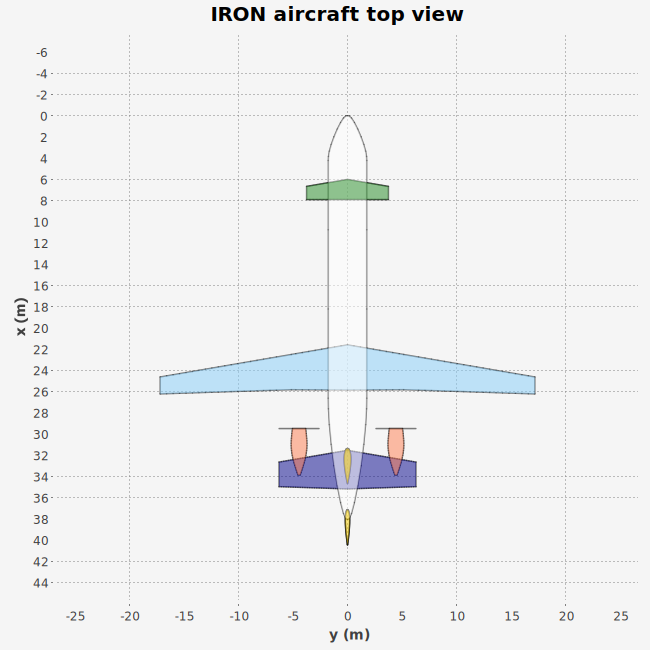

In [6]:
// create the SVG
status = standaloneutils.aircraft.WriteUtils
    .writeAircraftTopViewToSVG(
        jpadTest.pathToAircraftTopViewSVG.toString(), 
        "IRON aircraft top view", 
        jpadTest.aircraft);

if (status) {
    println "File " + jpadTest.pathToAircraftTopViewSVG.toString() + " created."
    // show the SVG
    SVG(jpadTest.pathToAircraftTopViewSVG.toString())
} else
    println "Unable to create file " + jpadTest.pathToAircraftTopViewSVG.toString()

File .\images\IRON-aircraft-sideview.svg created.


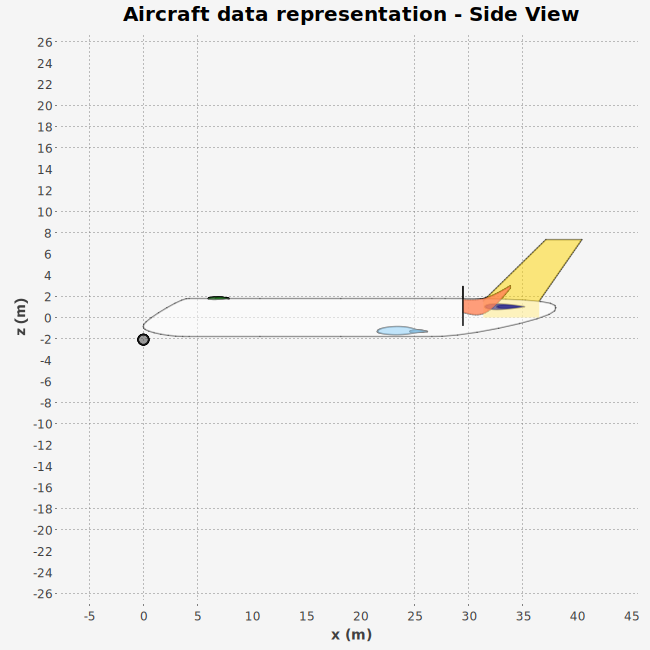

In [7]:
// create the SVG file
status = standaloneutils.aircraft.WriteUtils
    .writeAircraftSideViewToSVG(
        jpadTest.pathToAircraftSideViewSVG.toString(),
        "IRON aircraft side view",
        jpadTest.aircraft);

if (status) {
    println "File " + jpadTest.pathToAircraftSideViewSVG.toString() + " created."
    // show the SVG
    SVG(jpadTest.pathToAircraftSideViewSVG.toString())
} else
    println "Unable to create file " + jpadTest.pathToAircraftSideViewSVG.toString()